In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
import random
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import *

In [38]:
nx = 4
nu = 2
T = 40
start_point = np.array([0, 0, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs_act = 1.5
obs0 = Obstacle(10, 8, 2, obs_act, 'Obs0')
obs1 = Obstacle(3.5, 2, 1, obs_act, 'Obs1')
obs2 = Obstacle(8, 7, 1, obs_act, 'Obs2')
obs3 = Obstacle(4.5, 6, 1, obs_act, 'Obs3')
# obs4 = Obstacle(4, 4, 1, obs_act, 'Obs4')
# obs5 = Obstacle(6, 7.5, 1, obs_act, 'Obs5')
# obs6 = Obstacle(7.5, 3, 1, obs_act, 'Obs6')
# obs7 = Obstacle(5, 1, 1, obs_act, 'Obs7')
# obs8 = Obstacle(2.5, 2, 1, obs_act, 'Obs8')
obs_set = [obs1, obs2, obs3]#, obs4, obs5, obs6, obs7, obs8]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)
# cost_set.add_cost(obs4)
# cost_set.add_cost(obs5)
# cost_set.add_cost(obs6)
# cost_set.add_cost(obs7)
# cost_set.add_cost(obs8)

nr = cost_set.nr

In [39]:
# Desired Weights
w_run_possibles = np.array([10, 1., 1., 2000, 2000, 2000, 2000, 1000, 2000, 2000, 2000])
w_term_possibles = np.array([2000, 1., 1., 1000, 1000, 1000, 500, 0, 1000, 1000, 1000])
w_run = w_run_possibles[:nr]
w_term = w_term_possibles[:nr]
obs_set = obs_set[:nr]
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()

In [40]:
x0 = start_point
u0 = np.array([0.0, 0.0])
timeStep = 5e-2
max_iter = 500
XS_Set_optimal, US_Set_optimal = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_des, timeStep, max_iter, with_callback = False)
xs_optimal = XS_Set_optimal[0]
us_optimal = US_Set_optimal[0]
# xs_optimal, us_optimal, _ = get_results_from_model(cost_set, x0, u0, T, w_des, timeStep, max_iter, with_callback = True)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.01000e+02  1.01000e+02  3.46624e+01  1.0000  0.00000e+00  9.96889e+00
   2  1.73152e+00  1.73152e+00  2.39370e+00  1.0000  2.68674e-14  1.88100e-01
   3  1.61230e+00  1.61230e+00  1.58952e+00  1.0000  5.21115e-09  2.68380e-02
   4  1.55817e+00  1.55817e+00  3.36089e+01  0.5000  3.54763e-09  5.53877e-01
   5  1.41243e+00  1.41243e+00  3.24922e+00  1.0000  3.64354e-08  9.45345e-02
   6  1.37442e+00  1.37442e+00  1.21292e+01  1.0000  7.24848e-09  1.62008e-01
   7  1.34823e+00  1.34823e+00  6.16173e+00  1.0000  2.56891e-08  2.59717e-02
   8  1.33588e+00  1.33588e+00  2.01804e+00  1.0000  1.30890e-08  1.09951e-02
   9  1.33549e+00  1.33549e+00  2.58768e+00  1.0000  4.16472e-09  1.45733e-02
  10  1.33543e+00  1.33543e+00  7.66722e-01  1.0000  6.29499e-09  4.41519e-03
iter     merit         cost         grad      step    ||gaps||        KKT
  11  1.33533e+00  1.33533e+00  3.25197e-02  1.0000  1.46463e-09  1.9260

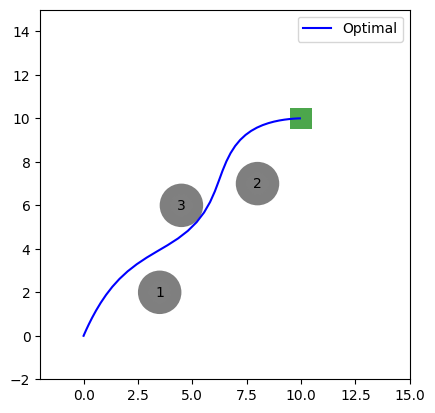

In [41]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())
plot_1_traj(np.vstack(xs_optimal), obs_set, target_high, label='Optimal', linemap = 'b')

In [42]:
# Bad Running and Terminal Model
w_bad = np.zeros_like(w_des)
w_run = w_bad[:nr]
w_term = w_bad[nr:]

xs_non_optimal, us_non_optimal, sqp_non_opt = get_results_from_model(cost_set, x0, u0, T, w_bad, timeStep, max_iter, with_callback = False)

In [43]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())
# plot_1_traj(np.vstack(xs_non_optimal), obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [263]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    factor = 1e-6
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    opt_traj_cost = cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt)
    num += np.exp(-opt_traj_cost)
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        non_opt_traj_cost = cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt)
        o = np.exp(factor*(opt_traj_cost - non_opt_traj_cost)**2)
        den += np.max([np.nextafter(0,1),o*np.exp(-non_opt_traj_cost)])
        # den += np.max([np.nextafter(0,1),np.exp(-non_opt_traj_cost)])
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_new(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, w_old, Lambda = 0.001):
    factor = 1/1000
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    opt_traj_cost = cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt)
    num += np.exp(-opt_traj_cost)
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        non_opt_traj_cost = cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt)
        o = np.exp(factor*(opt_traj_cost - non_opt_traj_cost)**2)
        # den += np.max([np.nextafter(0,1),o*np.exp(-non_opt_traj_cost)])
        den += np.max([np.nextafter(0,1),np.exp(-non_opt_traj_cost)])
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x - w_old)
    return output

def fcn_w_2D(x, cost_set, xs_optimal, us_optimal, xs_non_optimal, us_non_optimal, dt, Lambda = 0.001):
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    den += np.exp(-cost_set.traj_cost(xs_non_optimal, us_non_optimal, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

In [315]:
dt = timeStep
Lambda = 0.0
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 2, 'iprint': -1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10

w0 = w_bad
w_prev = w0
it = 0
max_set_size = 2
# it_max_IRL = max_set_size + 1
it_max_IRL = 15
it_max_sqp = 5

xs = []
us = []
ws = []
Fcns= []
Cost_Diffs = []
W_Diffs = []
Traj_Diffs = []

xs_non_optimal_set = []
us_non_optimal_set = []
xs_non_optimal_set.append(np.vstack(xs_non_optimal).copy())
us_non_optimal_set.append(np.vstack(us_non_optimal).copy())
xs.append(np.vstack(xs_non_optimal).copy())
us.append(np.vstack(us_non_optimal).copy())
ws.append(w_bad)

init_choices = ['bad','optimal','previous']
stochastic = False
w_tol = 0.00001
traj_tol = 1e-10
w_diff = 1
traj_diff = 1
e = 1
while traj_diff > traj_tol and it < it_max_IRL:
    
    # With simple regulation: ||w||
    res = minimize(fcn_w, 
                   w0, 
                   args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda), 
                   bounds=bnds, 
                   method='L-BFGS-B', 
                   tol = tol,
                   options=options)
    
    # # With simple new regulation: ||w - w_old||
    # res = minimize(fcn_w_new, 
    #                w0, 
    #                args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, w_prev, Lambda), 
    #                bounds=bnds, 
    #                method='L-BFGS-B', 
    #                tol = tol,
    #                options=options)
    
    w_loop = res.x.copy()
    w_loop /= np.max(w_loop)

    fcn_value = fcn_w(w_loop, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda)
    # fcn_value = 0.0
    Fcns.append(fcn_value)
    w_run = w_loop[:nr]
    w_term = w_loop[nr:]
    for i in range(T):
        sqp_non_opt.problem.runningModels[i].differential.model.costWeights = w_run
    sqp_non_opt.problem.terminalModel.differential.model.costWeights = w_term
    sqp_non_opt.with_callbacks=False

    # initial = random.choice(init_choices)
    initial = 'previous'
    if initial == 'previous':
        # Warm-Start with previous trajectory
        xs_init = [sqp_non_opt.xs.copy()[i] for i in range(T+1)]
        us_init = [sqp_non_opt.us.copy()[i] for i in range(T)]
    elif initial == 'optimal':
        # Warm-Start with optimal trajectory
        xs_init = [xs_optimal[i] for i in range(T+1)]
        us_init = [us_optimal[i] for i in range(T)]
    elif initial == 'bad':
        # Warm-Start with zero trajectory
        xs_init = [x0 for i in range(T+1)]
        us_init = [u0 for i in range(T)]
    
    done = sqp_non_opt.solve(xs_init, us_init, it_max_sqp)
    
    # Add the trajectory to the set
    xs.append(np.vstack(sqp_non_opt.xs.tolist().copy()))
    us.append(np.vstack(sqp_non_opt.us.tolist().copy()))
    ws.append(w_loop.copy())
    
    if len(xs_non_optimal_set) <= max_set_size:
        xs_non_optimal_set = xs
        us_non_optimal_set = us
    else:
        if not stochastic:
            xs_non_optimal_set = xs[-max_set_size:]
            us_non_optimal_set = us[-max_set_size:]
        else:
            xs_non_optimal_set = random.choices(xs, k=max_set_size)
            us_non_optimal_set = random.choices(us, k=max_set_size)
        
    
    opt_diff = (cost_set.traj_cost(sqp_non_opt.xs.copy(), sqp_non_opt.us.copy(), w_des[:nr], w_des[nr:], dt)- 
                cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], dt))**2
    w_diff = np.linalg.norm(w_loop - w_prev)
    traj_diff = (sqp_non_opt.cost - cost_set.traj_cost(xs_optimal, us_optimal, w_loop[:nr], w_loop[nr:], dt))**2
    Cost_Diffs.append(opt_diff)
    W_Diffs.append(w_diff)
    Traj_Diffs.append(traj_diff)
    if it > 0:
        print('Fcn Value: {:.4f} || Weight Diff: {:.4f} || Traj Diff: {:.4f}, || Optimal Diff: {:.4f}'.format(
            fcn_value, w_diff, traj_diff, opt_diff
        ))
    
    # Initial W for IRL as previous weights
    w0 = w_loop.copy()
    
    w_prev = w0
    it += 1
    if it == it_max_IRL-1:
        options['maxiter'] = 2
        xs_non_optimal_set = xs
        us_non_optimal_set = us

print(res)
w_irl = res.x/np.max(res.x)

Fcn Value: 0.0000 || Weight Diff: 0.2901 || Traj Diff: 8710.9252, || Optimal Diff: 97.4256
Fcn Value: 0.2147 || Weight Diff: 0.7360 || Traj Diff: 28.3100, || Optimal Diff: 0.4182
Fcn Value: 0.6091 || Weight Diff: 0.3050 || Traj Diff: 0.0025, || Optimal Diff: 0.0600
Fcn Value: 3.6648 || Weight Diff: 0.1965 || Traj Diff: 18.7681, || Optimal Diff: 2.6077
Fcn Value: 1.4734 || Weight Diff: 0.0029 || Traj Diff: 11.7381, || Optimal Diff: 0.6695
Fcn Value: 323.9438 || Weight Diff: 0.9943 || Traj Diff: 122639.9650, || Optimal Diff: 615.5797
Fcn Value: 16.2436 || Weight Diff: 0.9961 || Traj Diff: 323.6955, || Optimal Diff: 7.4310
Fcn Value: 1.4928 || Weight Diff: 0.3842 || Traj Diff: 0.0007, || Optimal Diff: 0.0413
Fcn Value: 1.6267 || Weight Diff: 0.0008 || Traj Diff: 0.0374, || Optimal Diff: 0.0009
Fcn Value: 28.8247 || Weight Diff: 0.9967 || Traj Diff: 974.7080, || Optimal Diff: 39.0827
Fcn Value: 22.2556 || Weight Diff: 0.0196 || Traj Diff: 872.0408, || Optimal Diff: 44.6192
Fcn Value: 1.842

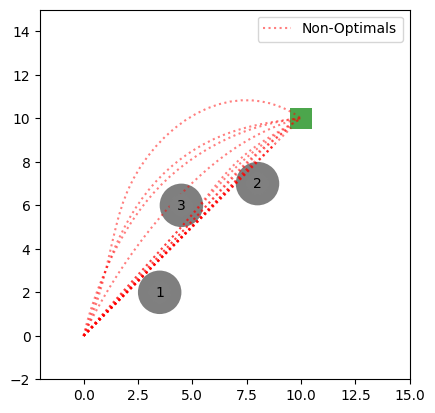

In [316]:
plot_1_set(xs, obs_set, target_high, label='Non-Optimals', linemap_traj='r:', linemap_set='r:')

In [317]:
w_irl = res.x/np.max(res.x)
w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.005 IRL:  0.0
Terminal ||  Desired:  1.0 IRL:  1.0

XReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.0

UReg :
Running ||  Desired:  0.0005 IRL:  0.0003798903861615084
Terminal ||  Desired:  0.0005 IRL:  0.0

Obs1 :
Running ||  Desired:  1.0 IRL:  0.077107185529141
Terminal ||  Desired:  0.5 IRL:  0.0

Obs2 :
Running ||  Desired:  1.0 IRL:  0.25423666873459627
Terminal ||  Desired:  0.5 IRL:  0.19992038935625714

Obs3 :
Running ||  Desired:  1.0 IRL:  0.10131509341189716
Terminal ||  Desired:  0.5 IRL:  0.0008593264590829288



In [318]:
print('Desired:                 ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda)) 
print('IRL:                     ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs, us, dt, Lambda))
print('')
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))
print('with IRL Weight:         ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
print('')
print('IRL Trajectory Cost:     ', cost_set.traj_cost(xs[-1], us[-1], w_irl[:nr], w_irl[nr:], timeStep))
print('with Desired Weight:     ', cost_set.traj_cost(xs[-1], us[-1], w_des[:nr], w_des[nr:], timeStep))

Desired:                  2.1450166722631634
IRL:                      2.2253232511489447

Desired Trajectory Cost:  1.3353346709574858
with IRL Weight:          0.1980894887050716

IRL Trajectory Cost:      0.10587557225189265
with Desired Weight:      1.0227271604881796


In [319]:
# plot_results(xs_optimal, xs[:-1], xs[-1], obs_set, target_high)

10 Trajectories Collected
20 Trajectories Collected
30 Trajectories Collected
Trajectory 32 Rejected
Trajectory 33 Rejected
40 Trajectories Collected
Trajectory 43 Rejected
Trajectory 46 Rejected
Trajectory 47 Rejected
50 Trajectories Collected
60 Trajectories Collected
70 Trajectories Collected
Trajectory 77 Rejected
Trajectory 78 Rejected
80 Trajectories Collected
Trajectory 87 Rejected
90 Trajectories Collected
100 Trajectories Collected


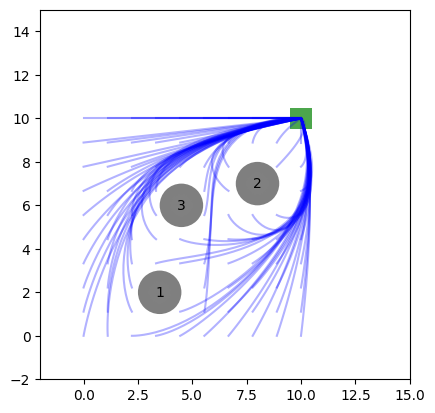

0


In [320]:
samples = 10
xlims = [0, 10]
ylims = [0, 10]
XS_Set, US_Set = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_irl, timeStep, max_iter, with_callback = False)
print(plot_tested_model(XS_Set, obs_set, target_high))

In [ ]:
# XS_Set_optimal, US_Set_optimal = test_model_full(cost_set, obs_set, samples, xlims, ylims, T, w_des, timeStep, max_iter, with_callback = False)
print(plot_tested_model(XS_Set_optimal, obs_set, target_high))

In [297]:
# Testing
w_run = w_irl[:nr]
w_term = w_irl[nr:]
# w_run = w_des[:nr]
# w_term = w_des[nr:]
# w_run = ws[n][:nr]
# w_term = ws[n][nr:]

x0 = start_point
# x0 = np.array([5.0, 3.5, 0.0, 0.0])
u0 = np.array([0.0, 0.0])

xs_output, us_output, sqp = get_results_from_model(cost_set, x0, u0, T, w_irl, timeStep, max_iter, with_callback = True)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  1.00744e+02  1.00744e+02  3.62815e+01  1.0000  0.00000e+00  9.98487e+00
   2  5.78171e-01  5.78171e-01  6.85637e+00  1.0000  2.58682e-14  4.57072e-02
   3  5.14478e-01  5.14478e-01  2.59490e+00  1.0000  1.06957e-08  3.36216e-02
   4  5.07591e-01  5.07590e-01  1.75056e+00  1.0000  5.03232e-09  3.11194e-03
   5  5.07113e-01  5.07113e-01  5.76943e-01  1.0000  3.39121e-09  3.91233e-04
   6  5.07034e-01  5.07034e-01  4.02742e-02  1.0000  1.35725e-09  3.59019e-05
 END  5.07034e-01  5.07034e-01  2.12205e-04   ----   7.76583e-11  1.07228e-07


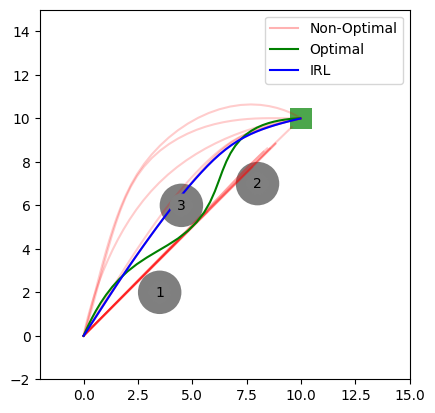

In [298]:
plot_results(xs_optimal, xs, xs_output, obs_set, target_high)

In [299]:
# creating sets
all_set_x = []
all_set_u = []
training_set_x = []
training_set_u = []

all_set_x.append(xs[-1]); all_set_x.append(xs_optimal); training_set_x.append(xs_optimal)
all_set_u.append(us[-1]); all_set_u.append(us_optimal); training_set_u.append(us_optimal)

for X, U in zip(xs, us):
    all_set_x.append(X); training_set_x.append(X)
    all_set_u.append(U); training_set_u.append(U)

In [300]:
P_irl = distributions(cost_set, training_set_x, training_set_u, w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, training_set_x, training_set_u, w_des[:nr], w_des[nr:], dt)

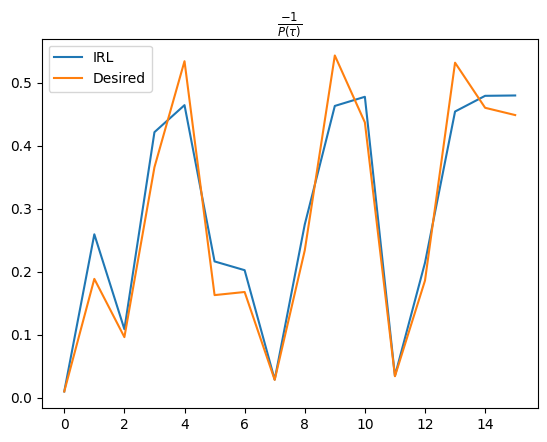

In [301]:
plt.plot(-1/np.log(P_irl[1:]),label='IRL')
plt.plot(-1/np.log(P_des[1:]),label='Desired')
plt.legend()
plt.gca().set_title(r'$\frac{-1}{P(\tau)}$')
plt.show()

In [302]:
# # Add a noisy trajectory to the set
# # scale = 1/traj_diff + 1.0
# scale = 5.0
# noisy_u = np.vstack(sqp_non_opt.us.tolist().copy())+np.random.normal(0.0,scale,np.stack(sqp_non_opt.us.tolist()).shape)
# us.append(noisy_u)
# xs.append(np.stack(problem.rollout([noisy_u[i] for i in range(T)])))